# XGBOOST
Objetivo: Entrenar modelo XGBoost con hiperparámetros por defecto para comparar con el baseline (Regresión Logística).

Fases temporales:
- T0 (Matrícula)          : Variables disponibles al momento de inscripción
- T1 (Fin 1er Semestre)   : T0 + variables académicas del 1er semestre, información de matrícula y deudor
- T2 (Fin 2do Semestre)   : T1 + variables académicas del 2do semestre

Preprocesamiento específico para XGBoost:
- No requiere escalado
- Label Encoding para categóricas
- Target Encoding para 'course'

Pipeline:
1. Carga de datos preprocesados
2. Definición de variables por fase temporal
3. Split estratificado (80/20)
4. Preprocesamiento específico para XGBoost
5. Entrenamiento con Cross-Validation 5-fold
6. Evaluación en test set
7. Comparación de resultados por fase

## 0. Librerias y configuración

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder

# Modelo
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# Target Encoding
from category_encoders import TargetEncoder

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directorio de salida
OUTPUT_DIR = "../outputs/figures/modelado/XGBoost/"
OUTPUT_DIR_REPORTES = "../outputs/models/XGBoost/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR_REPORTES, exist_ok=True)

# mlflow
import mlflow
import mlflow.sklearn

## 1. Carga de datos preprocesados

In [3]:
# Cargar dataset preprocesado
df = pd.read_csv('../data/processed/preprocessed_data.csv')

print(f"Dataset cargado: {df.shape[0]} filas x {df.shape[1]} columnas")
print(df['target_binario'].value_counts())
print(f"\nRatio de desbalance: {df['target_binario'].value_counts()[0] / df['target_binario'].value_counts()[1]:.2f}:1")

df.head()

Dataset cargado: 4424 filas x 36 columnas
target_binario
0    3003
1    1421
Name: count, dtype: int64

Ratio de desbalance: 2.11:1


,application_order,course,daytimeevening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,is_single,application_mode_risk,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,target_binario
0,5,171,1,122.0000,127.3000,1,0,0,1,1,0,20,0,0,0,0,0,0.0000,0,0,0,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,1
1,1,9254,1,160.0000,142.5000,1,0,0,0,1,0,19,0,0,6,6,6,14.0000,0,0,6,6,6,13.6667,0,13.9000,-0.3000,0.7900,1,Bajo_Riesgo,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0
2,5,9070,1,122.0000,124.8000,1,0,0,0,1,0,19,0,0,6,0,0,0.0000,0,0,6,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,1
3,2,9773,1,122.0000,119.6000,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4000,0,9.4000,-0.8000,-3.1200,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0
4,1,8014,0,100.0000,141.5000,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0000,0,13.9000,-0.3000,0.7900,0,Alto_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0


## 2. Definición de variables por fase temporal (T0, T1, T2)

In [4]:
# TARGET
TARGET = 'target_binario'

# -----------------------------------------------------------------------------
# VARIABLES BINARIAS (no requieren encoding, ya son 0/1)
# -----------------------------------------------------------------------------
VARS_BINARIAS_T0 = [
    'daytimeevening_attendance',
    'displaced',
    'educational_special_needs',
    'gender',
    'scholarship_holder',
    'international',
    'is_single'
]

VARS_BINARIAS_T1 = [
    'debtor',
    'tuition_fees_up_to_date'
]


# -----------------------------------------------------------------------------
# VARIABLES NUMÉRICAS (NO requieren escalado para XGBoost)
# -----------------------------------------------------------------------------
VARS_NUMERICAS_T0 = [
    'age_at_enrollment',
    'admission_grade',
    'previous_qualification_grade'
]

VARS_NUMERICAS_T1 = [
    'curricular_units_1st_sem_credited',
    'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations',
    'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade',
    'curricular_units_1st_sem_without_evaluations',
    'unemployment_rate',
    'inflation_rate',
    'gdp'
]

VARS_NUMERICAS_T2 = [
    'curricular_units_2nd_sem_credited',
    'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations',
    'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade',
    'curricular_units_2nd_sem_without_evaluations'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS AGRUPADAS (requieren Label Encoding para XGBoost)
# -----------------------------------------------------------------------------
VARS_CATEGORICAS_AGRUPADAS_T0 = [
    'application_mode_risk',
    'previous_qualification_risk',
    'mothers_qualification_level',
    'fathers_qualification_level',
    'mothers_occupation_level',
    'fathers_occupation_level'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS PARA TARGET ENCODING
# -----------------------------------------------------------------------------
VARS_TARGET_ENCODING_T0 = ['course']

# -----------------------------------------------------------------------------
# VARIABLE ORDINAL (se trata como numérica)
# -----------------------------------------------------------------------------
VARS_ORDINALES_T0 = ['application_order']

# =============================================================================
# COMPOSICIÓN DE VARIABLES POR FASE TEMPORAL
# =============================================================================

# T0: Variables disponibles al momento de matrícula
VARS_T0 = (
    VARS_BINARIAS_T0 +
    VARS_NUMERICAS_T0 +
    VARS_CATEGORICAS_AGRUPADAS_T0 +
    VARS_TARGET_ENCODING_T0 +
    VARS_ORDINALES_T0
)

# T1: T0 + variables del 1er semestre
VARS_T1 = (
    VARS_T0 +
    VARS_BINARIAS_T1 +
    VARS_NUMERICAS_T1
)

# T2: T1 + variables del 2do semestre
VARS_T2 = (
    VARS_T1 +
    VARS_NUMERICAS_T2
)

print("================================================================================")
print("  VARIABLES POR FASE TEMPORAL")
print("================================================================================")
print(f"\n T0 (Matrícula): {len(VARS_T0)} variables")
print(f" T1 (Fin 1er Sem): {len(VARS_T1)} variables (+{len(VARS_T1) - len(VARS_T0)})")
print(f" T2 (Fin 2do Sem): {len(VARS_T2)} variables (+{len(VARS_T2) - len(VARS_T1)})")

  VARIABLES POR FASE TEMPORAL

 T0 (Matrícula): 18 variables
 T1 (Fin 1er Sem): 29 variables (+11)
 T2 (Fin 2do Sem): 35 variables (+6)


## 3. Split TRAIN/TEST 

In [5]:
# Split se hace en totalidad del dataste, posteriormente se seleccionan las variables según la fase temporal para entrenemiento y evaluaciónl

X = df[VARS_T2].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("================================================================================")
print("  SPLIT TRAIN/TEST")
print("================================================================================")
print(f"\nTrain: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nDistribución del target en Train:")
print(y_train.value_counts())
print(f"Ratio de desbalance:: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

print(f"\nDistribución del target en Test:")
print(y_test.value_counts())
print(f"Ratio de desbalance:: {y_test.value_counts()[0] / y_test.value_counts()[1]:.2f}:1")

  SPLIT TRAIN/TEST

Train: 3539 (80.0%)
Test:  885 (20.0%)

Distribución del target en Train:
target_binario
0    2402
1    1137
Name: count, dtype: int64
Ratio de desbalance:: 2.11:1

Distribución del target en Test:
target_binario
0    601
1    284
Name: count, dtype: int64
Ratio de desbalance:: 2.12:1


## 4. Funciones de preprocesamiento para XGBOOST

In [6]:
def obtiene_variables_por_fase(fase):
    # Retorna las listas de variables según la fase temporal, retorna diccionario con variables de la fase
    if fase == 'T0':
        return {
            'binarias': VARS_BINARIAS_T0,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T0
        }
    elif fase == 'T1':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T1
        }
    elif fase == 'T2':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1 + VARS_NUMERICAS_T2,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T2
        }
    else:
        raise ValueError(f"Fase no válida: {fase}. Usar 'T0', 'T1', o 'T2'")


def preprocesamiento_xgboost(X_train, X_test, y_train, fase):
    # Preprocesa los datos para XGBoost    
    variables_fase = obtiene_variables_por_fase(fase)
    
    # Seleccionar solo las variables de la fase
    X_train_fase = X_train[variables_fase['all']].copy()
    X_test_fase = X_test[variables_fase['all']].copy()
    
    # Diccionario para guardar encoders
    label_encoders = {}
    
    # -------------------------------------------------------------------------
    # 1. TARGET ENCODING para 'course' 
    # -------------------------------------------------------------------------
    te = TargetEncoder(cols=variables_fase['categoricas_te'], smoothing=0.3)
    
    for col in variables_fase['categoricas_te']:
        X_train_fase[col + '_encoded'] = te.fit_transform(X_train_fase[[col]], y_train)[col]
        X_test_fase[col + '_encoded'] = te.transform(X_test_fase[[col]])[col]
        # Eliminar columna original
        X_train_fase = X_train_fase.drop(columns=[col])
        X_test_fase = X_test_fase.drop(columns=[col])
    
    # -------------------------------------------------------------------------
    # 2. LABEL ENCODING para categóricas agrupadas
    # -------------------------------------------------------------------------
    for col in variables_fase['categoricas_le']:
        le = LabelEncoder()
        X_train_fase[col] = le.fit_transform(X_train_fase[col].astype(str))
        X_test_fase[col] = le.transform(X_test_fase[col].astype(str))
        label_encoders[col] = le
    
    # -------------------------------------------------------------------------
    # Guardar información
    # -------------------------------------------------------------------------
    variables = X_train_fase.columns.tolist()
    preprocessors = {
        'target_encoder': te,
        'label_encoders': label_encoders,
        'feature_names': variables
    }
    
    return X_train_fase, X_test_fase, variables, preprocessors

## 5. Funciones entrenamiento

In [7]:
# Entrenamiento con parámetros por defecto
def entrena_xgboost(X_train, y_train, fase, cv_folds=5):
    """Entrena y evalúa XGBoost con Cross-Validation."""

    mlflow.end_run()
         
    print("================================================================================")
    print(f"  ENTRENAMIENTO XGBOOST - FASE {fase}")
    print("================================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f"Registros: {X_train.shape[0]}")
    
    # -------------------------------------------------------------------------
    # Calcular scale_pos_weight para desbalance
    # -------------------------------------------------------------------------
    n_neg = (y_train == 0).sum()
    n_pos = (y_train == 1).sum()
    scale_pos_weight = n_neg / n_pos
    print(f"\nscale_pos_weight: {scale_pos_weight:.2f}")

    print(f"\nHiperparámetros (por defecto):")
    print(f"   • n_estimators: 100")
    print(f"   • max_depth: 6")
    print(f"   • learning_rate: 0.3")
    print(f"   • subsample: 1.0")
    print(f"   • colsample_bytree: 1.0")
    
    # -------------------------------------------------------------------------
    # Cross-Validation con loop manual
    # -------------------------------------------------------------------------
    print(f"\nCross-Validation ({cv_folds}-fold):")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # Almacenar resultados por fold
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }
    
    train_losses = []
    val_losses = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Crear y entrenar modelo
        modelo_xgb = XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.3,
            subsample=1.0,
            colsample_bytree=1.0,
            min_child_weight=1,
            gamma=0,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=scale_pos_weight,
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        #modelo_xgb.fit(X_fold_train, y_fold_train)
        modelo_xgb.fit(X_fold_train, y_fold_train,
                        eval_set=[(X_fold_train, y_fold_train), (X_fold_val, y_fold_val)],
                        verbose=False
        )

        # Obtiene historial de métricas
        results = modelo_xgb.evals_result()
        train_loss = results['validation_0']['logloss']
        val_loss = results['validation_1']['logloss']
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Predicciones
        y_train_pred = modelo_xgb.predict(X_fold_train)
        y_train_proba = modelo_xgb.predict_proba(X_fold_train)[:, 1]
        y_val_pred = modelo_xgb.predict(X_fold_val)
        y_val_proba = modelo_xgb.predict_proba(X_fold_val)[:, 1]
        
        # Métricas Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
        
        # Métricas Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
    

    # Calcular longitud mínima
    min_len = min(len(l) for l in train_losses)
    
    # Recortar y promediar
    train_losses_array = np.array([l[:min_len] for l in train_losses])
    val_losses_array = np.array([l[:min_len] for l in val_losses])
    
    train_mean = train_losses_array.mean(axis=0)
    train_std = train_losses_array.std(axis=0)
    val_mean = val_losses_array.mean(axis=0)
    val_std = val_losses_array.std(axis=0)
    
    iterations = range(1, min_len + 1)
    
    # =========================================================================
    # GRAFICAR
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(iterations, train_mean, label='Train Loss', color='#3498DB', linewidth=2)
    ax.fill_between(iterations, train_mean - train_std, train_mean + train_std, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(iterations, val_mean, label='Validation Loss', color='#E74C3C', linewidth=2)
    ax.fill_between(iterations, val_mean - val_std, val_mean + val_std, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xlabel('Iterations (n_estimators)', fontsize=12)
    ax.set_ylabel('Binary Logloss', fontsize=12)
    ax.set_title(f'Curva de Aprendizaje - XGBoost {fase}\n(Media ± Std de {cv_folds}-Fold CV) - Sin Optimizar', fontsize=14)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar punto de mejor validación
    best_iter = np.argmin(val_mean)
    ax.axvline(x=best_iter, color='green', linestyle='--', alpha=0.7)
    ax.scatter([best_iter], [val_mean[best_iter]], color='green', s=100, zorder=5,
               label=f'Mejor iteración: {best_iter}')
    ax.legend(loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_aprendizaje_xgboost_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular gap
    gap_final = train_mean[-1] - val_mean[-1]
    
    print(f"\n Resumen:")
    print(f"   Mejor iteración: {best_iter}")
    print(f"   Train Loss final: {train_mean[-1]:.4f}")
    print(f"   Val Loss final: {val_mean[-1]:.4f}")
    print(f"   Val Loss mínimo: {val_mean[best_iter]:.4f}")
    print(f"   Gap (Train - Val): {gap_final:.4f}")

    #####

    # Convertir a numpy arrays
    for key in cv_results:
        cv_results[key] = np.array(cv_results[key])
    
    # -------------------------------------------------------------------------
    # Resultados por fold
    # -------------------------------------------------------------------------
    print("\n Resultados por fold:")
    for i in range(cv_folds):
        print(f"\n  Fold {i+1}:")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_score = cv_results[f'train_{metric}'][i]
            val_score = cv_results[f'test_{metric}'][i]
            print(f"    {metric:<10} | Train: {train_score:.4f} | Val: {val_score:.4f}")


    mlflow.set_experiment("TFM_Dropout_Prediction")
    with mlflow.start_run(run_name=f"XGBoost_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Params por default')
        mlflow.set_tag("tipo", 'Validacion cruzada')
        mlflow.log_params(modelo_xgb.get_params())

        # -------------------------------------------------------------------------
        # Resumen CV (media ± std)
        # -------------------------------------------------------------------------
        print(f"\n Resumen Cross-Validation:")
        print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>12} {'Val Mean':>12} {'Val Std':>12}")
        print(f"   {'-'*60}")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_mean = cv_results[f'train_{metric}'].mean()
            train_std = cv_results[f'train_{metric}'].std()
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
            print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>12.4f} {val_mean:>12.4f} {val_std:>12.4f}")
    
    
    # -------------------------------------------------------------------------
    # Retornar resultados
    # -------------------------------------------------------------------------
    results = {
        'phase': fase,
        'model': modelo_xgb,
        'n_features': X_train.shape[1],
        'cv_results': cv_results,
    }
    
    return results



def resumen_cv(cv_results, fase, modelo):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    summary = {
        'modelo': modelo,
        'fase': fase
    }


    # -------------------------
    # Métricas de VALIDACIÓN
    # -------------------------
    for metric in metrics:
        summary[f'{metric}_val_mean'] = cv_results[f'test_{metric}'].mean()
        summary[f'{metric}_val_std']  = cv_results[f'test_{metric}'].std()
        

    # -------------------------
    # Métricas de TRAIN
    # -------------------------
    for metric in metrics:
        summary[f'{metric}_train_mean'] = cv_results[f'train_{metric}'].mean()
        summary[f'{metric}_train_std']  = cv_results[f'train_{metric}'].std()


    return pd.DataFrame([summary])

In [ ]:
# Optimización con optuna
import optuna

def entrena_xgboost_con_optuna(X_train, y_train, fase, n_trials=50, cv_folds=5):
    """
    Entrena Random Forest con optimización Optuna.
    Optimiza F1-score de clase Dropout (1) 
    """

    print("==========================================================================")
    print(f"  OPTIMIZACIÓN XGBOOST CON OPTUNA - FASE {fase}")
    print("==========================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f"Registros en train: {X_train.shape[0]}")
    print(f"Trials Optuna: {n_trials}")
    print(f"Métrica a optimizar: F1-score (clase Dropout)")

    # -------------------------------------------------------------------------
    # Calcular scale_pos_weight para desbalance
    # -------------------------------------------------------------------------
    n_neg = (y_train == 0).sum()
    n_pos = (y_train == 1).sum()
    scale_pos_weight = n_neg / n_pos
    print(f"\nscale_pos_weight: {scale_pos_weight:.2f}")

    
    # =========================================================================
    # FUNCIÓN OBJETIVO PARA OPTUNA
    # =========================================================================
    def objective(trial):
        
        # Hiperparámetros a optimizar
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 30),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
            'scale_pos_weight': trial.suggest_float(
                'scale_pos_weight',
                0.5 * scale_pos_weight,
                2.0 * scale_pos_weight
            )
        }
        
       
        # Cross-validation
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
        scores = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_fold_train = X_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_val = y_train.iloc[val_idx]
            
            try:
                modelo_xgb_opt_cv = XGBClassifier(**params) 
                modelo_xgb_opt_cv.fit(X_fold_train, y_fold_train)
                y_pred = modelo_xgb_opt_cv.predict(X_fold_val)
                
                # F1-score de clase 1 (Dropout)
                f1 = f1_score(y_fold_val, y_pred, pos_label=1)
                scores.append(f1)
                
            except Exception:
                return 0.0
        
        return np.mean(scores)

        
    # =========================================================================
    # EJECUTAR OPTIMIZACIÓN
    # =========================================================================
    print(f"\nProceso de optimización")
    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    
    study = optuna.create_study(
        direction='maximize',
        study_name=f'F1-socre_{fase}',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    # =========================================================================
    # MEJORES HIPERPARÁMETROS
    # =========================================================================
    best_params = study.best_params
    best_f1_score = study.best_value
    
    
    print(f"\n{'='*70}")
    print(f"  MEJORES HIPERPARÁMETROS")
    print(f"{'='*70}")
    print(f"  Mejor F1-score (CV): {best_f1_score:.4f}")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    
    # =========================================================================
    # EVALUACIÓN FINAL CON MEJORES PARAMS
    # =========================================================================
    final_params = {
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'min_child_weight': best_params['min_child_weight'],
        'gamma': best_params['gamma'],
        'reg_alpha': best_params.get('reg_alpha', 0),
        'reg_lambda': best_params.get('reg_lambda', 1),
        'scale_pos_weight': best_params['scale_pos_weight'],
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }

    # CV final con todas las métricas
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }
    
    train_losses = []
    val_losses = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        modelo_xgb_opt = XGBClassifier(**final_params, verbosity=0)
        modelo_xgb_opt.fit(X_fold_train, y_fold_train,
                        eval_set=[(X_fold_train, y_fold_train), (X_fold_val, y_fold_val)],
                        verbose=False
        )

        # Obtener historial de métricas
        results = modelo_xgb_opt.evals_result()
        train_loss = results['validation_0']['logloss']
        val_loss = results['validation_1']['logloss']
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        y_train_pred = modelo_xgb_opt.predict(X_fold_train)
        y_train_proba = modelo_xgb_opt.predict_proba(X_fold_train)[:, 1]
        y_val_pred = modelo_xgb_opt.predict(X_fold_val)
        y_val_proba = modelo_xgb_opt.predict_proba(X_fold_val)[:, 1]
        
        # Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
        
        # Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
    

    # Calcular longitud mínima
    min_len = min(len(l) for l in train_losses)
    
    # Recortar y promediar
    train_losses_array = np.array([l[:min_len] for l in train_losses])
    val_losses_array = np.array([l[:min_len] for l in val_losses])
    
    train_mean = train_losses_array.mean(axis=0)
    train_std = train_losses_array.std(axis=0)
    val_mean = val_losses_array.mean(axis=0)
    val_std = val_losses_array.std(axis=0)
    
    iterations = range(1, min_len + 1)
    
    # =========================================================================
    # GRAFICAR
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(iterations, train_mean, label='Train Loss', color='#3498DB', linewidth=2)
    ax.fill_between(iterations, train_mean - train_std, train_mean + train_std, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(iterations, val_mean, label='Validation Loss', color='#E74C3C', linewidth=2)
    ax.fill_between(iterations, val_mean - val_std, val_mean + val_std, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xlabel('Iterations (n_estimators)', fontsize=12)
    ax.set_ylabel('Binary Logloss', fontsize=12)
    ax.set_title(f'Curva de Aprendizaje - XGBoost {fase}\n(Media ± Std de {cv_folds}-Fold CV) - Optimizado', fontsize=14)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar punto de mejor validación
    best_iter = np.argmin(val_mean)
    ax.axvline(x=best_iter, color='green', linestyle='--', alpha=0.7)
    ax.scatter([best_iter], [val_mean[best_iter]], color='green', s=100, zorder=5,
               label=f'Mejor iteración: {best_iter}')
    ax.legend(loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_aprendizaje_xgboost_opt_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular gap
    gap_final = train_mean[-1] - val_mean[-1]
    
    print(f"\n Resumen:")
    print(f"   Mejor iteración: {best_iter}")
    print(f"   Train Loss final: {train_mean[-1]:.4f}")
    print(f"   Val Loss final: {val_mean[-1]:.4f}")
    print(f"   Val Loss mínimo: {val_mean[best_iter]:.4f}")
    print(f"   Gap (Train - Val): {gap_final:.4f}")

    #####

    for key in cv_results:
        cv_results[key] = np.array(cv_results[key])
    
    # =========================================================================
    # RESUMEN CV
    # =========================================================================
    print(f"\n{'='*70}")
    print(f"  RESUMEN CROSS-VALIDATION (Optimizado)")
    print(f"{'='*70}")
    print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>10} {'Val Mean':>12} {'Val Std':>10}")
    print(f"   {'-'*60}")
    
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        val_mean = cv_results[f'test_{metric}'].mean()
        val_std = cv_results[f'test_{metric}'].std()
        marker = "****" if metric == 'f1' else ""

        print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>10.4f} {val_mean:>12.4f} {val_std:>10.4f}{marker}")


    with mlflow.start_run(run_name=f"Optuna_XGBoost_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Baseline - Optimizado_Optuna')
        mlflow.set_tag("tipo", 'Validacion cruzada')
        mlflow.log_params(modelo_xgb_opt.get_params())
        mlflow.log_param("n_trials", n_trials)
        mlflow.log_param("cv_folds", cv_folds)
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_metric("optuna_best_f1_cv", best_f1_score)
    
    
    # =========================================================================
    # MODELO FINAL PARA Entrenamiento previo a la evaluacion
    # =========================================================================
        #model_final = LogisticRegression(**final_params)
        #model_final.fit(X_train, y_train)

        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
        

    # =========================================================================
    # RETORNAR
    # =========================================================================
    results = {
        'fase': fase,
        'model': modelo_xgb_opt,
        'best_params': best_params,
        'best_f1_sore_cv': best_f1_score,
        'cv_results': cv_results,
        'study': study,
        #'run_id': run_id
    }

    return results


## 6. Modelado FASE T0 (MATRÍCULA)

In [9]:
# Preprocesamiento para T0
X_train_T0, X_test_T0, features_T0, prep_T0 = preprocesamiento_xgboost(
    X_train, X_test, y_train, fase='T0'
)

print(f"\nT0 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T0.shape}")
print(f"   Test:  {X_test_T0.shape}")
print(f"   Variables: {len(features_T0)}")
print(f"   \nLas variables son:")
X_train_T0.columns



T0 - Dimensiones después del preprocesamiento:
   Train: (3539, 18)
   Test:  (885, 18)
   Variables: 18
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'course_encoded'],
      dtype='object')

### Parametros por defecto

  ENTRENAMIENTO XGBOOST - FASE T0

Variables: 18
Registros: 3539

scale_pos_weight: 2.11

Hiperparámetros (por defecto):
   • n_estimators: 100
   • max_depth: 6
   • learning_rate: 0.3
   • subsample: 1.0
   • colsample_bytree: 1.0

Cross-Validation (5-fold):


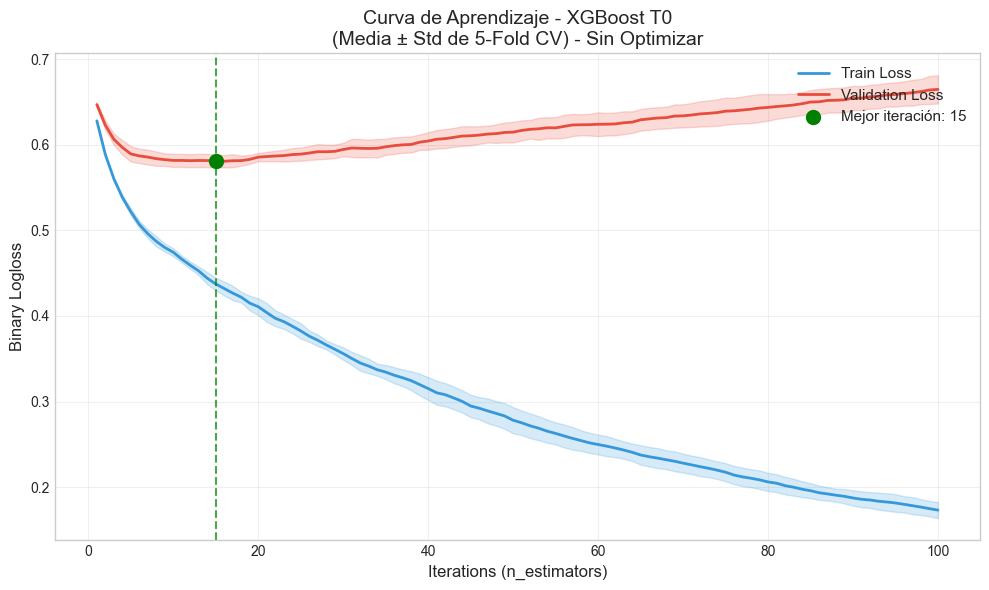


 Resumen:
   Mejor iteración: 15
   Train Loss final: 0.1733
   Val Loss final: 0.6646
   Val Loss mínimo: 0.5806
   Gap (Train - Val): -0.4913

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.9700 | Val: 0.7020
    precision  | Train: 0.9383 | Val: 0.5399
    recall     | Train: 0.9703 | Val: 0.5044
    f1         | Train: 0.9540 | Val: 0.5215
    roc_auc    | Train: 0.9967 | Val: 0.7090

  Fold 2:
    accuracy   | Train: 0.9820 | Val: 0.7020
    precision  | Train: 0.9574 | Val: 0.5374
    recall     | Train: 0.9879 | Val: 0.5351
    f1         | Train: 0.9724 | Val: 0.5363
    roc_auc    | Train: 0.9990 | Val: 0.7137

  Fold 3:
    accuracy   | Train: 0.9749 | Val: 0.6907
    precision  | Train: 0.9439 | Val: 0.5161
    recall     | Train: 0.9802 | Val: 0.5639
    f1         | Train: 0.9617 | Val: 0.5389
    roc_auc    | Train: 0.9980 | Val: 0.7110

  Fold 4:
    accuracy   | Train: 0.9717 | Val: 0.6921
    precision  | Train: 0.9368 | Val: 0.5188
    recall     | Train:

In [10]:
# Entrenar y evaluar T0
results_T0 = entrena_xgboost(X_train_T0, y_train, fase='T0')

df_resumen_xgboost = resumen_cv(
    cv_results=results_T0['cv_results'],
    fase='T0',
    modelo='XGBoost'
)
# Guardar tabla de comparación
df_resumen_xgboost.to_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_XGBoost.csv", index=False)

print(f"Resultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_XGBoost.csv")

### Optimización

  OPTIMIZACIÓN XGBOOST CON OPTUNA - FASE T0

Variables: 18
Registros en train: 3539
Trials Optuna: 50
Métrica a optimizar: F1-score (clase Dropout)

scale_pos_weight: 2.11

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.5932
    n_estimators: 18
    max_depth: 10
    learning_rate: 0.29329050461199757
    subsample: 0.862175825734035
    colsample_bytree: 0.8754006721464517
    min_child_weight: 12
    gamma: 2.9636695314901975
    reg_alpha: 1.3236482379573162
    reg_lambda: 6.610901060130805
    scale_pos_weight: 2.2778953496449925


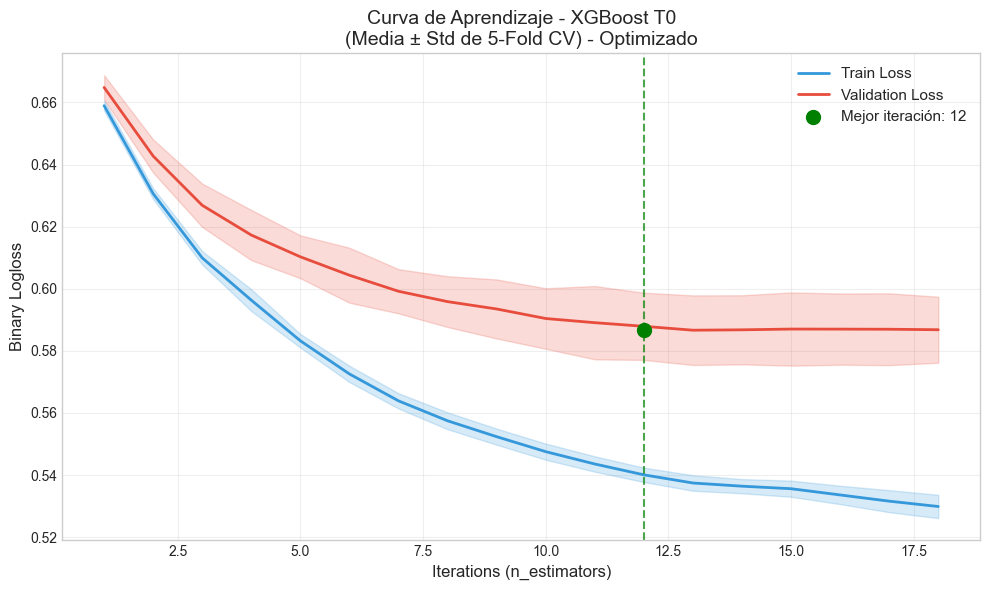


 Resumen:
   Mejor iteración: 12
   Train Loss final: 0.5299
   Val Loss final: 0.5868
   Val Loss mínimo: 0.5866
   Gap (Train - Val): -0.0569

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.7354     0.0057       0.6883     0.0077
   precision          0.5636     0.0075       0.5112     0.0102
   recall             0.7830     0.0044       0.7116     0.0233
   f1                 0.6554     0.0039       0.5946     0.0048****
   roc_auc            0.8264     0.0028       0.7586     0.0052
🏃 View run Optuna_XGBoost_CV5_T0 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/5acb389bf0d044e0ab0a5ec0a05c7507
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.5241
  Optuna:   0.5932

Resultados guardados en: ../outputs/models/XGBoost/cv_summary_XGBoost.csv


In [11]:
results_T0_optuna = entrena_xgboost_con_optuna(X_train_T0, y_train, fase='T0', n_trials=50)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T0['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T0_optuna['best_f1_sore_cv']:.4f}")

df_resumen_xgb_T0_opt = resumen_cv(
    cv_results=results_T0_optuna['cv_results'],
    fase='T0',
    modelo='XGBoost_opt'
)

xgb_path = "../outputs/models/XGBoost/cv_summary_XGBoost.csv"
df_xgb = pd.read_csv(xgb_path)
df_final = pd.concat([df_xgb, df_resumen_xgb_T0_opt], ignore_index=True)
csv_path = "cv_summary_XGBoost.csv"

# Guardar tabla de comparación
df_final.to_csv(xgb_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_XGBoost.csv")

### Comentarios FASE 0

1. Se observa que todas las métricas en entrenamiento alcanzan casi el valor máximo (1.0) lo que indica sobreentrenamiento fuerte, aunque ligeramente menor en comparación con RF en Fase 0. El recall en validación es 0.5445, inferior RL.
2. Las métricas de validación caen de forma relevente, en proemdio 0.2276, en consecuencia, no generaliza adecuadamente y desviación standard presentan mayor variación (promedio 0.0201)
3. XGBoost no aporta ventaja en fase T0 y presenta sobreajuste.

## 7. Modelado FASE T1 (FIN 1ER SEMESTRE)

In [12]:
# Preprocesamiento para T1
X_train_T1, X_test_T1, features_T1, prep_T1 = preprocesamiento_xgboost(
    X_train, X_test, y_train, fase='T1'
)

print(f"\nT1 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T1.shape}")
print(f"   Test:  {X_test_T1.shape}")
print(f"   Features: {len(features_T1)}")
print(f"   \nLas variables son:")
X_train_T1.columns


T1 - Dimensiones después del preprocesamiento:
   Train: (3539, 29)
   Test:  (885, 29)
   Features: 29
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'debtor', 'tuition_fees_up_to_date',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations', 'unemployment_rate',
       'inflation_rate', 'gdp', 'course_encoded'],
      dtype='object')

### Parámetros por defecto

  ENTRENAMIENTO XGBOOST - FASE T1

Variables: 29
Registros: 3539

scale_pos_weight: 2.11

Hiperparámetros (por defecto):
   • n_estimators: 100
   • max_depth: 6
   • learning_rate: 0.3
   • subsample: 1.0
   • colsample_bytree: 1.0

Cross-Validation (5-fold):


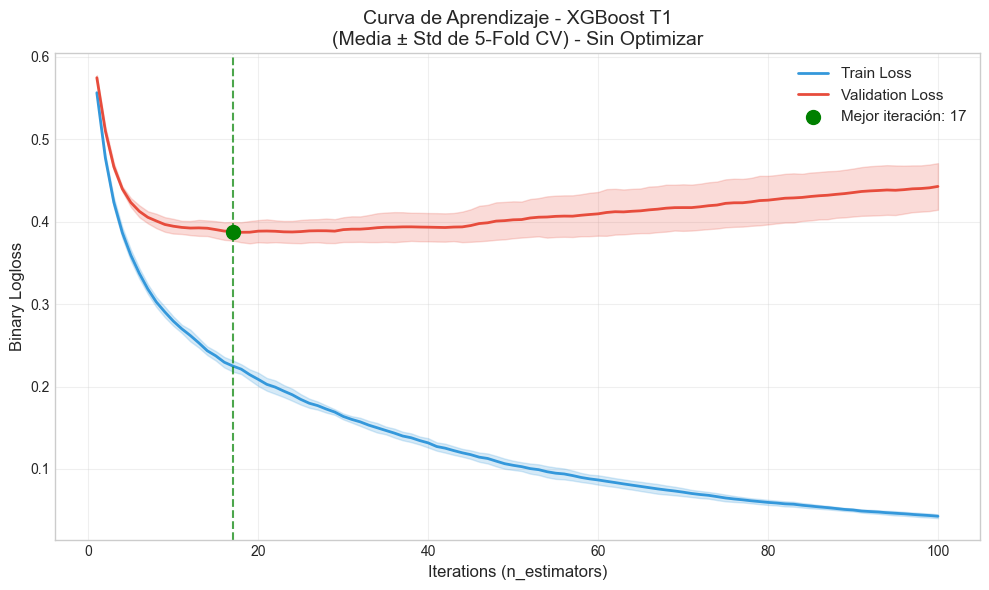


 Resumen:
   Mejor iteración: 17
   Train Loss final: 0.0427
   Val Loss final: 0.4427
   Val Loss mínimo: 0.3871
   Gap (Train - Val): -0.4000

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 1.0000 | Val: 0.8404
    precision  | Train: 1.0000 | Val: 0.7602
    recall     | Train: 1.0000 | Val: 0.7368
    f1         | Train: 1.0000 | Val: 0.7483
    roc_auc    | Train: 1.0000 | Val: 0.8785

  Fold 2:
    accuracy   | Train: 0.9996 | Val: 0.8333
    precision  | Train: 0.9989 | Val: 0.7644
    recall     | Train: 1.0000 | Val: 0.6974
    f1         | Train: 0.9995 | Val: 0.7294
    roc_auc    | Train: 1.0000 | Val: 0.8783

  Fold 3:
    accuracy   | Train: 0.9996 | Val: 0.8164
    precision  | Train: 0.9989 | Val: 0.7175
    recall     | Train: 1.0000 | Val: 0.7048
    f1         | Train: 0.9995 | Val: 0.7111
    roc_auc    | Train: 1.0000 | Val: 0.8879

  Fold 4:
    accuracy   | Train: 0.9996 | Val: 0.8376
    precision  | Train: 0.9989 | Val: 0.7617
    recall     | Train:

In [13]:
# Entrenar y evaluar T1
results_T1 = entrena_xgboost(X_train_T1, y_train, fase='T1')

df_resumen_XGBoost_T1 = resumen_cv(
    cv_results=results_T1['cv_results'],
    fase='T1',
    modelo='XGBoost'
)

xgb_path = "../outputs/models/XGBoost/cv_summary_XGBoost.csv"
df_xgb = pd.read_csv(xgb_path)
df_final = pd.concat([df_xgb, df_resumen_XGBoost_T1], ignore_index=True)

# Guardar tabla de comparación
df_final.to_csv(xgb_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_XGBoost.csv")

### Optimización

  OPTIMIZACIÓN XGBOOST CON OPTUNA - FASE T1

Variables: 29
Registros en train: 3539
Trials Optuna: 50
Métrica a optimizar: F1-score (clase Dropout)

scale_pos_weight: 2.11

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.7617
    n_estimators: 28
    max_depth: 7
    learning_rate: 0.28972246910739907
    subsample: 0.825721127601667
    colsample_bytree: 0.7626513874391809
    min_child_weight: 2
    gamma: 1.396337387406754
    reg_alpha: 5.292765005613637
    reg_lambda: 7.38150818780978
    scale_pos_weight: 1.5594112352478258


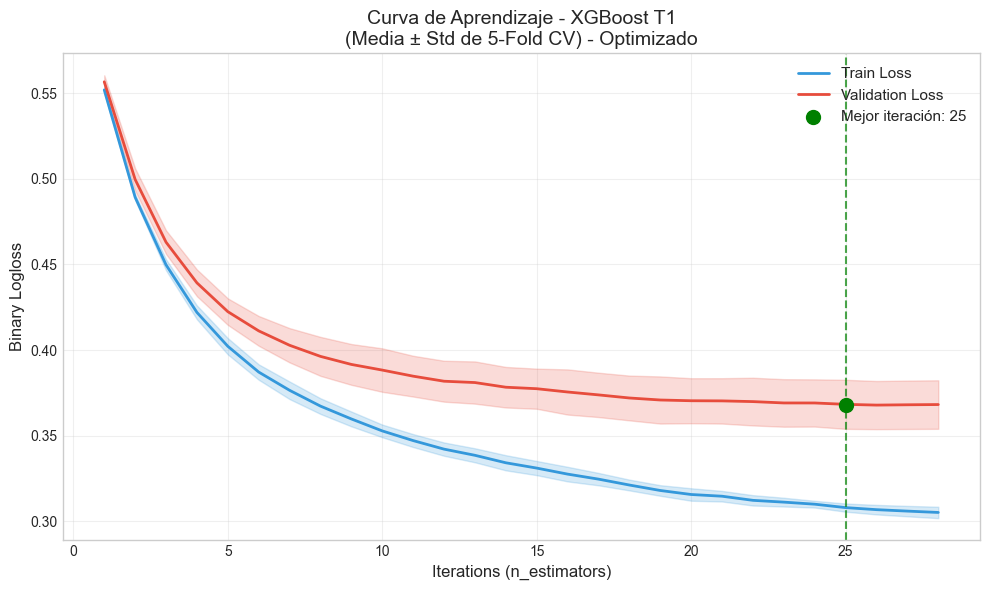


 Resumen:
   Mejor iteración: 25
   Train Loss final: 0.3051
   Val Loss final: 0.3681
   Val Loss mínimo: 0.3678
   Gap (Train - Val): -0.0630

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.8781     0.0028       0.8469     0.0115
   precision          0.8185     0.0039       0.7716     0.0250
   recall             0.7975     0.0061       0.7450     0.0304
   f1                 0.8079     0.0047       0.7575     0.0188****
   roc_auc            0.9381     0.0015       0.8956     0.0115
🏃 View run Optuna_XGBoost_CV5_T1 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/94f18fccc6ad4f519bd6221166d2d215
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.7382
  Optuna:   0.7617

Resultados guardados en: ../outputs/models/XGBoost/cv_summary_XGBoost.csv


In [14]:
results_T1_optuna = entrena_xgboost_con_optuna(X_train_T1, y_train, fase='T1', n_trials=50)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T1['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T1_optuna['best_f1_sore_cv']:.4f}")

df_resumen_xgb_T1_opt = resumen_cv(
    cv_results=results_T1_optuna['cv_results'],
    fase='T1',
    modelo='XGBoost_opt'
)

xgb_path = "../outputs/models/XGBoost/cv_summary_XGBoost.csv"
df_xgb = pd.read_csv(xgb_path)
df_final = pd.concat([df_xgb, df_resumen_xgb_T1_opt], ignore_index=True)
csv_path = "cv_summary_XGBoost.csv"

# Guardar tabla de comparación
df_final.to_csv(xgb_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_XGBoost.csv")


### Comentarios FASE 1

1. Se observa que casi la totalidad de las métricas en entrenamiento alcanzan el valor máximo (1.0) lo que indica sobreentrenamiento severo. El recall en validación es 0.7071, similar a RL y RF.
2. Las métricas de validación caen de forma relevente, en promedio 0.12, en consecuencia, no generaliza adecuadamente. Desviación standard presentan menor variación (promedio 0.0138) que la Fase 0 presentando una estabilidad relativa.

## 8. Modelado FASE T2 (FIN 2DO SEMESTRE)

In [15]:
# Preprocesamiento para T2
X_train_T2, X_test_T2, features_T2, prep_T2 = preprocesamiento_xgboost(
    X_train, X_test, y_train, fase='T2'
)

print(f"\nT2 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T2.shape}")
print(f"   Test:  {X_test_T2.shape}")
print(f"   Features: {len(features_T2)}")
print(f"   \nLas variables son:")
X_train_T2.columns



T2 - Dimensiones después del preprocesamiento:
   Train: (3539, 35)
   Test:  (885, 35)
   Features: 35
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'debtor', 'tuition_fees_up_to_date',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations', 'unemployment_rate',
       'inflation_rate', 'gdp', 'curricular_units_2nd_sem_credited',
       'curricular_units_2nd_sem_enrolled',
       'curricular_units_2nd_sem_evaluations',
       'curricular_units_2nd_sem_approved', 'curricular_units_2nd

  ENTRENAMIENTO XGBOOST - FASE T2

Variables: 35
Registros: 3539

scale_pos_weight: 2.11

Hiperparámetros (por defecto):
   • n_estimators: 100
   • max_depth: 6
   • learning_rate: 0.3
   • subsample: 1.0
   • colsample_bytree: 1.0

Cross-Validation (5-fold):


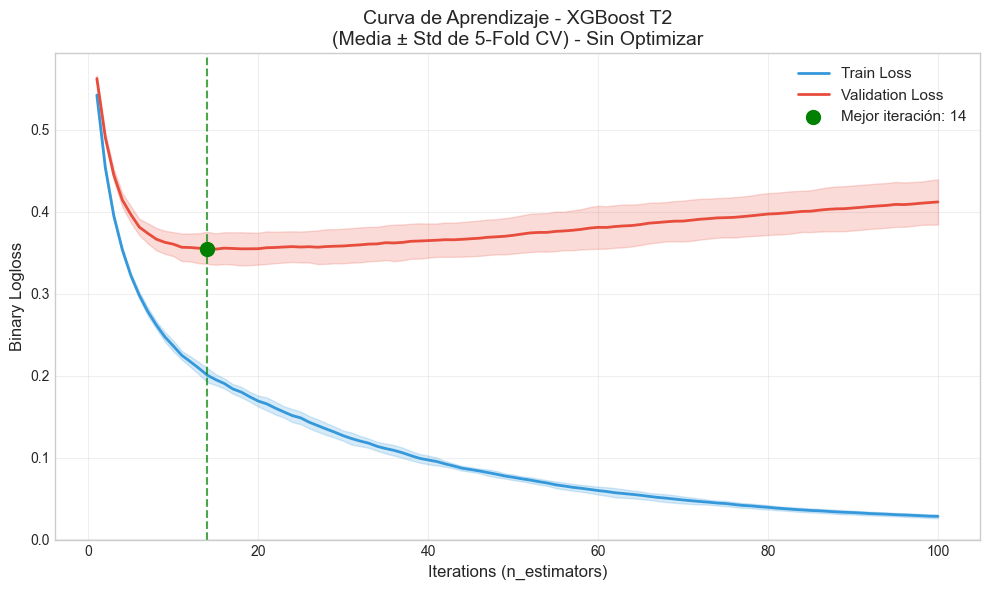


 Resumen:
   Mejor iteración: 14
   Train Loss final: 0.0282
   Val Loss final: 0.4119
   Val Loss mínimo: 0.3543
   Gap (Train - Val): -0.3836

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.9996 | Val: 0.8573
    precision  | Train: 0.9989 | Val: 0.7822
    recall     | Train: 1.0000 | Val: 0.7719
    f1         | Train: 0.9995 | Val: 0.7770
    roc_auc    | Train: 1.0000 | Val: 0.8944

  Fold 2:
    accuracy   | Train: 1.0000 | Val: 0.8503
    precision  | Train: 1.0000 | Val: 0.7824
    recall     | Train: 1.0000 | Val: 0.7412
    f1         | Train: 1.0000 | Val: 0.7613
    roc_auc    | Train: 1.0000 | Val: 0.9039

  Fold 3:
    accuracy   | Train: 1.0000 | Val: 0.8559
    precision  | Train: 1.0000 | Val: 0.7934
    recall     | Train: 1.0000 | Val: 0.7445
    f1         | Train: 1.0000 | Val: 0.7682
    roc_auc    | Train: 1.0000 | Val: 0.9043

  Fold 4:
    accuracy   | Train: 1.0000 | Val: 0.8602
    precision  | Train: 1.0000 | Val: 0.8107
    recall     | Train:

In [16]:
# Entrenar y evaluar T2
results_T2 = entrena_xgboost(X_train_T2, y_train, fase='T2')

df_resumen_XGBoost_T2 = resumen_cv(
    cv_results=results_T2['cv_results'],
    fase='T2',
    modelo='XGBoost'
)

xg_path = "../outputs/models/XGBoost/cv_summary_XGBoost.csv"
df_xg = pd.read_csv(xg_path)
df_final = pd.concat([df_xg, df_resumen_XGBoost_T2], ignore_index=True)

# Guardar tabla de comparación
df_final.to_csv(xg_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_XGBoost.csv")

### Optimización

  OPTIMIZACIÓN XGBOOST CON OPTUNA - FASE T2

Variables: 35
Registros en train: 3539
Trials Optuna: 50
Métrica a optimizar: F1-score (clase Dropout)

scale_pos_weight: 2.11

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.7926
    n_estimators: 24
    max_depth: 9
    learning_rate: 0.18440681948596327
    subsample: 0.6383843568334897
    colsample_bytree: 0.6779435558674338
    min_child_weight: 7
    gamma: 0.24169057630230034
    reg_alpha: 5.0489785946419365
    reg_lambda: 8.955734970554587
    scale_pos_weight: 1.3303028526832474


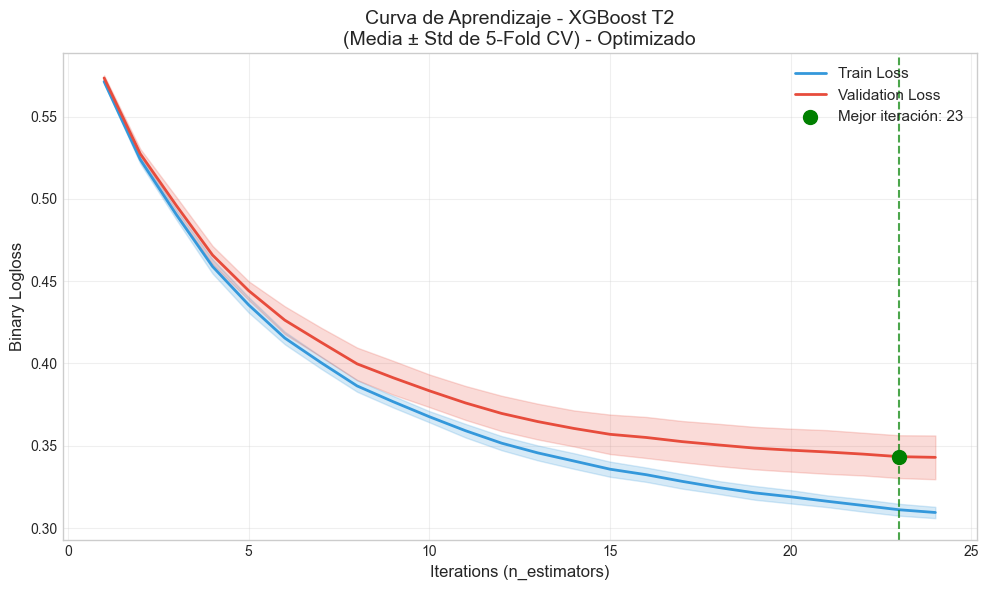


 Resumen:
   Mejor iteración: 23
   Train Loss final: 0.3095
   Val Loss final: 0.3429
   Val Loss mínimo: 0.3429
   Gap (Train - Val): -0.0335

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.8840     0.0018       0.8695     0.0080
   precision          0.8475     0.0053       0.8260     0.0210
   recall             0.7792     0.0071       0.7529     0.0146
   f1                 0.8119     0.0032       0.7875     0.0121****
   roc_auc            0.9329     0.0019       0.9092     0.0104
🏃 View run Optuna_XGBoost_CV5_T2 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/dce39e37adfd4b689d0a9354762d8c2b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.7739
  Optuna:   0.7926

Resultados guardados en: ../outputs/models/XGBoost/cv_summary_XGBoost.csv


In [17]:
results_T2_optuna = entrena_xgboost_con_optuna(X_train_T2, y_train, fase='T2', n_trials=50)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T2['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T2_optuna['best_f1_sore_cv']:.4f}")

df_resumen_xgb_T2_opt = resumen_cv(
    cv_results=results_T2_optuna['cv_results'],
    fase='T2',
    modelo='XGBoost_opt'
)

xgb_path = "../outputs/models/XGBoost/cv_summary_XGBoost.csv"
df_xgb = pd.read_csv(xgb_path)
df_final = pd.concat([df_xgb, df_resumen_xgb_T2_opt], ignore_index=True)
csv_path = "cv_summary_XGBoost.csv"

# Guardar tabla de comparación
df_final.to_csv(xgb_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_XGBoost.csv")

### Comentarios FASE 2

1. Continua presentando las métricas en entrenamiento con valor máximo (1.0) lo que indica sobreentrenamiento severo. El recall en validación es 0.7485 y un AUC 0.9080, reflejando mayor capacidad predictiva.
2. Las métricas de validación caen de forma relevente, en promedio 0.2544, en consecuencia, no generaliza adecuadamente.  Desviación standard presentan mayor variación (promedio 0.0162) mejor que la fase 2.

## 9. Resumen Final XGBoost

In [18]:
# Mostrar resumen final
df_final = pd.read_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_XGBoost.csv")

print("================================================================================")
print("  RESUMEN XGBoost - CROSS VALIDATION")
print("================================================================================")
print(df_final.to_string(index=False))

  RESUMEN XGBoost - CROSS VALIDATION
     modelo fase  accuracy_val_mean  accuracy_val_std  precision_val_mean  precision_val_std  recall_val_mean  recall_val_std  f1_val_mean  f1_val_std  roc_auc_val_mean  roc_auc_val_std  accuracy_train_mean  accuracy_train_std  precision_train_mean  precision_train_std  recall_train_mean  recall_train_std  f1_train_mean  f1_train_std  roc_auc_train_mean  roc_auc_train_std
    XGBoost   T0             0.6883            0.0174              0.5157             0.0265           0.5339          0.0206       0.5241      0.0173            0.7130           0.0091               0.9745              0.0041                0.9435               0.0074             0.9793            0.0056         0.9611        0.0063              0.9976             0.0008
XGBoost_opt   T0             0.6883            0.0077              0.5112             0.0102           0.7116          0.0233       0.5946      0.0048            0.7586           0.0052               0.7354       

## 10. Resumen completo de entrenamiento (Todos los algoritmos)

In [19]:
resumen_path = "../outputs/models/cv_summary_entrenamiento.csv"
df_resumen = pd.read_csv(resumen_path)

xg_path = "../outputs/models/XGBoost/cv_summary_XGBoost.csv"
df_xg = pd.read_csv(xg_path)

df_resumen = pd.concat([df_resumen, df_xg], ignore_index=True)

# Guardar tabla de comparación
df_resumen.to_csv(f"../outputs/models/cv_summary_entrenamiento.csv", index=False)

print(f"Resultados guardados en: ../outputs/models/cv_summary_entrenamiento.csv")

Resultados guardados en: ../outputs/models/cv_summary_entrenamiento.csv


## Conclusión

Aunque XGBoost presenta desviaciones standard moderadas mas altas que RL y similares a RF, estan se disminuyen en la medida que se agrega más información. En comparación con RF presenta mejor recall, AUC y menor varianza, sin emabargo, al comparar con RL, este algoritmo presenta menor capacidad de detectar a los estudiantes desertores y menor capacidad de discriminación. Si bien presenta una mejora relevante al incoporar información académica en las fases 1 y 2, presenta un sobreaprendizaje en el conjunto de entrenamiento, lo cual sugiere la necesidad de una optmización adecuada de los los hiperparámetros.